### Contextual Integration Example, for a vanilla RNN trained with BPTT

Authored by D. Sussillo.

Here is the code to implement a vanilla RNN to do a version of the contextual integration task in Mante, Sussillo et al.  There are two white noise inputs, whose form is 

$u(t) = b + \eta(t)$ 

with $\eta(t)$ drawn from properly scaled white noise. The bias term, $b$, is drawn from a properly scaled uniform distribution.  The idea is to make the 'psychometric curve' difficult by calibrating the bias and the noise level such that guessing the sign of the bias varies from very easy to very difficult.  

In addition to the white noise input, the RNN recieves a contextual signal, a very simple 2D one-hot signal which tells the system to pay to attention to one of the two white noise inputs, while ignoring the other.  

In Mante & Sussillo the desired output was either a +1/-1 at time $T$ depending on whether the bias term of the contextually relevant input was $>0$ or $< 0$. Here, instead the desired target is the integral of the contextually relevant white noise input, i.e. $f(t) = \int_0^t u(s) ds$.  

This code requires the `autograd` package (https://github.com/HIPS/autograd)

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt

Calibrate the difficulty of the task.

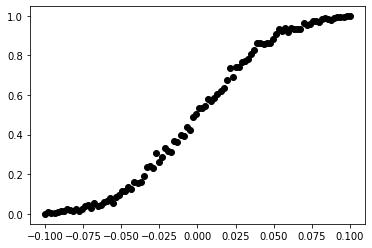

In [3]:
T = 1.0
ntime = 100
dt = T/float(ntime)

bval = 0.1
sval = 0.04
ntrials = 400
biases_ex1 = bval * np.linspace(-1, 1, 100)

for bias in biases_ex1: 
    stddev = sval / np.sqrt(dt)
    noise_ext = stddev * np.random.randn(ntrials, ntime)
    trials_ext = bias + noise_ext
    int_trials_ext = dt * np.cumsum(trials_ext, axis=1)
    plt.plot(bias, sum(int_trials_ext[:,-1] > 0)/float(ntrials), 'ko')  
    
plt.axis('tight');
plt.show()

Create the inputs and outputs for the contextual integration task.

dimension code: 

- t = time
- e = number examples
- b = batch_size
- w = white noise inputs
- u = input 
- n = hidden 
- m = output

In [4]:
def build_inputs_and_targets(ntrials, input_params, do_plot=False):
    bias_val, stddev_val, T, ntime = input_params
    dt = T/float(ntime)
    nwninputs = 2
    biases_1xexw = np.expand_dims(bias_val * 2.0 * (np.random.rand(ntrials,nwninputs) -0.5), axis=0)
    stddev = stddev_val / np.sqrt(dt)
    noise_txexw = stddev * np.random.randn(ntime, ntrials, nwninputs)
    white_noise_txexw = biases_1xexw + noise_txexw
    white_noise_txexw[0:5,:,:] = 0.0 # Allow context to establish before integration.

    context_ex1 = np.expand_dims(np.random.randint(0,2, ntrials), axis=1)
    context_ex2 = np.concatenate((context_ex1.astype(np.float64), 
                                  np.logical_not(context_ex1).astype(np.float64)), 
                                 axis=1)
    context_txex2 = np.repeat(np.expand_dims(context_ex2, axis=0), ntime, axis=0)

    inputs_txexu = np.concatenate((white_noise_txexw, context_txex2), axis=2)

    # Create the desired outputs
    # * dt, intentionally left off to get output scaling in O(1).
    int_wninputs_txexw = np.cumsum(white_noise_txexw, axis=0) 
    targets_txe = np.where(context_txex2[:,:,0], 
                           int_wninputs_txexw[:,:,0], 
                           int_wninputs_txexw[:,:,1])
    targets_txexm = np.expand_dims(targets_txe, axis=2) # single output, so m=1

    if do_plot:
        eidx = 0
        time = np.linspace(0, T, ntime)
        plt.figure(figsize=(13,6))
        plt.subplot(221)
        plt.plot(time, inputs_txexu[:,eidx,0:2]);
        plt.xlim([0,T])
        plt.ylabel('White-noise Inputs')
        plt.subplot(222)
        plt.plot(time, int_wninputs_txexw[:,eidx,:]);
        plt.xlim([0,T])
        plt.ylabel('Integrated Inputs')
        plt.subplot(223)
        plt.plot(time, inputs_txexu[:,eidx,2:])
        plt.xlim([0,T])
        plt.ylabel('Context')
        plt.subplot(224)
        plt.plot(time, targets_txexm[:,eidx,0], 'r')
        plt.title('Context {}'.format(context_txex2[0,eidx,:]))
        plt.xlim([0,T])
        plt.xlabel('Time')
        plt.ylabel('Output')
        plt.show()
        
    return inputs_txexu, targets_txexm

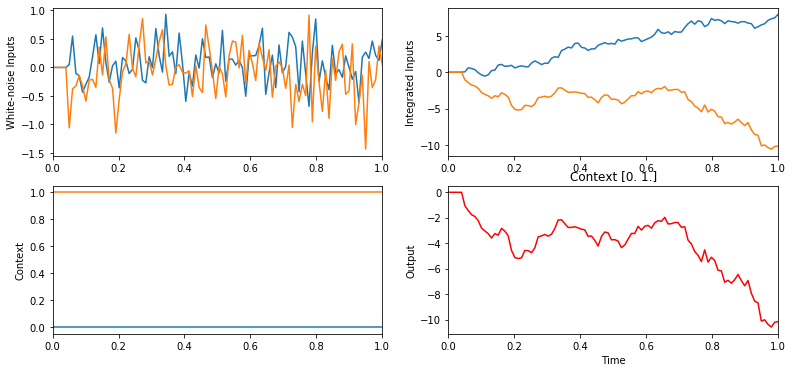

inputs shape:  (100, 128, 4)
targets shape:  (100, 128, 1)


In [5]:
batch_size = 128
input_params = (bval, sval, T, ntime)
inputs_txexu, targets_txexm = build_inputs_and_targets(batch_size, input_params, do_plot=True)

print("inputs shape: ", inputs_txexu.shape)
print("targets shape: ", targets_txexm.shape)

#### Implements the vanilla RNN.  Adapted from the autograd RNN tutorial example. 

In [6]:
from __future__ import absolute_import
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.scipy.special import logsumexp
from os.path import dirname, join
from builtins import range
from autograd.misc.optimizers import adam

Helper function

In [7]:
def concat_and_multiply(weights, *args):
    cat_state = np.hstack(args + (np.ones((args[0].shape[0], 1)),))
    return np.dot(cat_state, weights)

Define vanilla recurrent neural net

In [8]:
def create_rnn_params(input_size, state_size, output_size,
                      g=1.0, rs=npr.RandomState(0)):
    hscale = 1.0
    ifactor = 1.0 / np.sqrt(input_size)
    hfactor = g / np.sqrt(state_size + 1)
    pfactor = 1.0 / np.sqrt(state_size + 1)
    return {'init hiddens': rs.randn(1, state_size) * hscale,
            'change':       np.concatenate((rs.randn(input_size, state_size) * ifactor,
                                            rs.randn(state_size + 1, state_size) * hfactor),
                                           axis=0),
            'predict':      rs.randn(state_size + 1, output_size) * pfactor}

def rnn_predict(params, inputs_txbxu, do_return_hiddens=False):
    def update_rnn(input_bxu, hidden_bxn):
        return np.tanh(concat_and_multiply(params['change'], input_bxu, hidden_bxn))

    def hidden_to_output_probs(hidden_bxn):
        return concat_and_multiply(params['predict'], hidden_bxn)

    batch_size = inputs_txbxu.shape[1]
    hidden_bxn = np.repeat(params['init hiddens'], batch_size, axis=0)
    
    outputs_t = []
    hiddens_t = []
    for input_bxu in inputs_txbxu:  # Iterate over time steps.
        hidden_bxn = update_rnn(input_bxu, hidden_bxn)
        outputs_t.append(hidden_to_output_probs(hidden_bxn))
        if do_return_hiddens:
            hiddens_t.append(hidden_bxn)
    return outputs_t, hiddens_t

def rnn_mse(params, input_txbxu, target_txbxm):
    output_t_bxm, _ = rnn_predict(params, input_txbxu)
    output_txbxm = np.array(output_t_bxm)
    return np.mean((output_txbxm - target_txbxm)**2)

In [9]:
def train(state_size, g, batch_size, num_iters,
          input_params, init_params=None):
 
    # Allow continued training.
    if init_params is None:
        init_params = create_rnn_params(input_size=4, output_size=1,
                                        state_size=state_size, 
                                        g=g)
    def training_loss(params, iter):
        # We draw completely random inputs and targets, so no need
        # for a validation set.
        inputs_txbxu, targets_txbxm = \
            build_inputs_and_targets(batch_size, input_params)
        mse = rnn_mse(params, inputs_txbxu, targets_txbxm)
        l2_reg = 2e-6
        reg_loss = l2_reg * np.sum(params['change']**2)
        return mse + reg_loss

    def callback(weights, iter, gradient):
        if iter % 10 == 0:
            print("Iteration: ", iter, " Train loss:", training_loss(weights, 0))
            #print_training_prediction(weights)

    # Build gradient of loss function using autograd.
    training_loss_grad = grad(training_loss)
    trained_params = init_params
    init_step_size = 0.001
    nstep_sizes = 10
    for i, step_size in enumerate([init_step_size*(0.333333**n) for n in range(nstep_sizes)]):
        print("(%d/%d) Training RNN for %d steps at step size %f" % (i+1, nstep_sizes, num_iters, step_size))
        trained_params = adam(training_loss_grad, trained_params, step_size=step_size,
                              num_iters=num_iters, callback=callback)
        np.save("/tmp/CIRNN_trained_params", trained_params)
    print("Done.")
    return trained_params


In [10]:
state_size = 100
init_params = create_rnn_params(input_size=4, output_size=1,
                                state_size=state_size, g=0.9)
np.save("/tmp/CIRNN_init_params", init_params)

In [11]:
# This takes about 10 minutes on my laptop.

batch_size = 256
num_iters = 100
trained_params = train(state_size=state_size, g=0.9, 
                       batch_size=batch_size, num_iters=num_iters, input_params=input_params,
                       init_params=init_params)


(1/10) Training RNN for 100 steps at step size 0.001000
Iteration:  0  Train loss: 16.44316722371669
Iteration:  10  Train loss: 14.26163183023079
Iteration:  20  Train loss: 15.190839260661837
Iteration:  30  Train loss: 14.126060701540208
Iteration:  40  Train loss: 9.4576090952113
Iteration:  50  Train loss: 8.663010974555661
Iteration:  60  Train loss: 8.109219283136065
Iteration:  70  Train loss: 6.472464828791287
Iteration:  80  Train loss: 5.5601945218606295
Iteration:  90  Train loss: 4.3380594868737195
(2/10) Training RNN for 100 steps at step size 0.000333
Iteration:  0  Train loss: 3.6491651184061533
Iteration:  10  Train loss: 3.543033115358608
Iteration:  20  Train loss: 3.3449445311361434
Iteration:  30  Train loss: 2.7424204510969714
Iteration:  40  Train loss: 2.29203152109969
Iteration:  50  Train loss: 2.356054854708259
Iteration:  60  Train loss: 2.3621894530660463
Iteration:  70  Train loss: 2.320721498830184
Iteration:  80  Train loss: 2.197733027796221
Iteration: 

MSE for batch 0.235049
(100, 100)


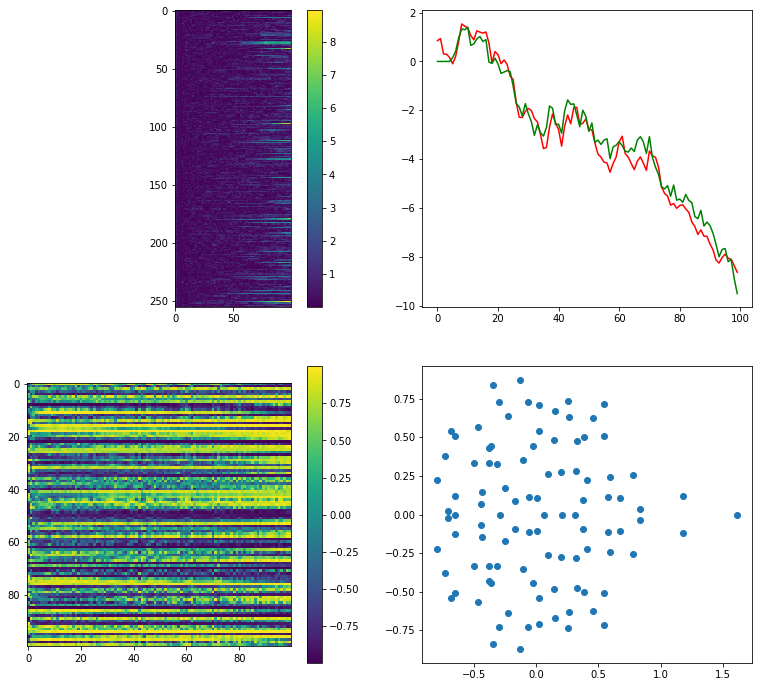

In [17]:
input_txbxu, target_txbxm = \
        build_inputs_and_targets(batch_size, input_params)
        
outputs_t_bxm, hiddens_t_bxm = \
        rnn_predict(trained_params, input_txbxu, do_return_hiddens=True)
hidden_txbxm = np.array(hiddens_t_bxm)
output_txbxm = np.array(outputs_t_bxm)

target_txb = np.squeeze(target_txbxm)
output_txb = np.squeeze(output_txbxm)

print("MSE for batch %.6f" % rnn_mse(trained_params, 
                                     input_txbxu[:,0:1,:], target_txbxm[:,0:1]))

bidx = 0
plt.figure(figsize=(13,12))
plt.subplot(221)
plt.imshow(np.abs(output_txb -target_txb).T, interpolation='none')
plt.colorbar()

plt.subplot(222)
plt.plot(output_txb[:,bidx], 'r')
plt.plot(target_txb[:,bidx], 'g')

plt.subplot(223)
plt.imshow(hidden_txbxm[:,bidx,:].T, interpolation='none')
plt.colorbar()

plt.subplot(224)
W = trained_params['change'][4:-1,:]
print(W.shape)
evals = np.linalg.eigvals(W)
#plt.imshow(params['change'], interpolation='none')
plt.plot(np.real(evals), np.imag(evals), 'o')


plt.show()